The following notebook implements the calculations described in [methodology](notebooks/2-methodology.ipynb) across all datetimes, whenever there are enough observations. For each datetime, the a SABR smile is calibrated (involving multiple iterations of least squares), then numerical differentiation is performed, then integration (twice, the second time to normalize the density), such that the whole program can take a long time to finish. The results are stored as a .csv file [here](../output/estimates/prob-nonparam.csv).

In [20]:
import sys; sys.path.append("..")  # to be able to access src/

import os
import pandas as pd
from scipy.integrate import simps
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.dates import DayLocator, DateFormatter, \
    WeekdayLocator, MO, MonthLocator

from optools.smile import SABR

from src.visuals import format_dataframe

In [40]:
# settings
DATA_PATH = Path("../data")
OUT_PATH = Path("../output")
MATURITY = 1/12
DATES = slice("2022-01-25", "2022-02-24")
EXAMPLE_DATE = "2022-02-24 03:48:00+01:00"

plt.style.use("seaborn-v0_8-colorblind")

# data

In [3]:
timeline = pd.read_csv(DATA_PATH / "raw" / "timeline.csv", 
                       index_col=0, parse_dates=True)
format_dataframe(timeline)

date,event
2022-02-11 11:34,blinken warns russia can attack during the olympics
2022-02-11 20:03,jake sullivan believes putin has decided to invade next week
2022-02-17 15:19,biden estimates prob of invasion as very high
2022-02-18 22:58,biden warns russia is planning attack in coming days
2022-02-24 04:06,putin announces special military operation


In [4]:
data = pd.read_feather(DATA_PATH / "processed" / "data.ftr")

# the dat alooks like this
format_dataframe(data.query(f"date == @EXAMPLE_DATE"), precision=4)

date,contract,value
2022-02-24 03:48,forward,82.1610
2022-02-24 03:48,r_base,0.0023
2022-02-24 03:48,spot,81.2420
2022-02-24 03:48,v_10b,0.0747
2022-02-24 03:48,v_10r,0.2661
2022-02-24 03:48,v_25b,0.0150
2022-02-24 03:48,v_25r,0.1221
2022-02-24 03:48,v_atm,0.3583
2022-02-24 03:48,r_counter,0.1293


In [5]:
# pivot for convenience, keep contracts with expiry > announcement date
data = data.pivot(index="date", columns="contract", values="value")\
    .loc[DATES].dropna()    

In the end we would like to iterate over the datetime values in `data`. Let's define a function that will for each row in the pivoted `data` calibrate a SABR smile.

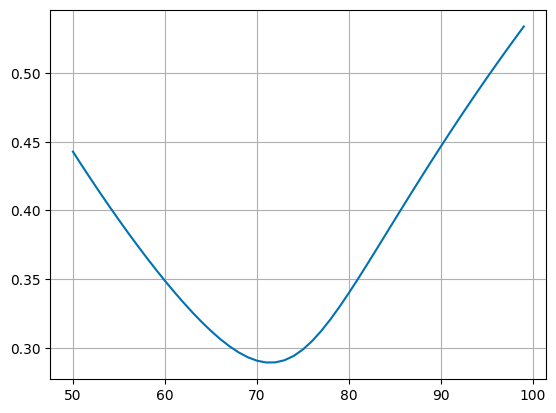

In [6]:
def sabr_getter(chunk: pd.Series):
    """Get SABR specification from a chunk of data."""
    sabr = SABR.fit_to_fx(
        tau=MATURITY,
        v_atm=chunk["v_atm"],
        contracts={0.1: {"ms": chunk["v_10b"],
                        "rr": chunk["v_10r"]},
                    0.25: {"ms": chunk["v_25b"],
                        "rr": chunk["v_25r"]}},
        delta_conventions={"atm_def": "dns",
                            "is_premiumadj": True,
                            "is_forward": False},
        **chunk[["spot", "forward", "r_counter"]])
    return sabr


sabr_getter(data.loc[EXAMPLE_DATE]).plot(domain=np.arange(50, 100))
plt.grid(axis="both")
plt.show()

Since calibration of SABR smiles is time-consuming, we will store the calibrated parameters for each datetime to a .csv file. We will be able to reuse these parameters when calculating $P[S>h]$ for different values of $h$.

In [7]:
if "sabr-estimated-parameters.csv" in os.listdir("../data/interim/"):
    # load
    par = pd.read_csv(
        "../data/interim/sabr-estimated-parameters.csv",
        index_col=0, parse_dates=True
    ).loc[DATES]
    
    par["forward"] = data.loc[par.index, "forward"]
    
    sabrs = par.apply(
        lambda _row: SABR(tau=MATURITY, **_row),
        axis=1
    ).squeeze()
else:
    # calibrate and save all SABRs (takes ~45 min)
    sabrs = {}
    for _t, _row in tqdm(data.iterrows()):
        try:
            sabrs[_t] = sabr_getter(_row)
        except:
            continue

    sabrs = pd.Series(sabrs)

    # save all parameters (except `forward` which is from bloomberg)
    pd.DataFrame.from_records(
        sabrs.map(lambda _x: [_x.volvol, _x.init_vola, _x.rho, _x.beta]),
        index=sabrs.index,
        columns=["volvol", "init_vola", "rho", "beta"]
    )\
        .rename_axis(index="date")\
        .to_csv("../data/interim/sabr-estimated-parameters.csv")

Given a volatility smile, we can estimate the probability of the underlying breaching a certain threshold: let's define a function for this which we could later apply to all smiles.

In [8]:
def prob_estimator(smile, r_counter, threshold):
    """Estimate risk-neutral probability of S > `threshold`."""
    # get rnd
    k_range = np.arange(smile.forward / 2, smile.forward * 1.75, 1e-04)
    rnd = smile.estimate_risk_neutral_density(
        rf=r_counter, forward=smile.forward,
        domain=k_range, normalize=True
    )

    # integrate rnd; two strikes are lost during differentiation
    idx = k_range[1:-1] > threshold

    # integrate over the range of strikes from threshold to 'infinity'
    res = simps(rnd[idx], k_range[1:-1][idx])

    return res

print(
    prob_estimator(
        sabrs.loc[EXAMPLE_DATE],
        data.loc[EXAMPLE_DATE, "r_counter"],
        threshold=85
    )
)

0.33885237440881066


And, finally, let's apply this function to all observations for a range of thresholds. This will take a long time, so we save the output, as with the SABR values before.

In [9]:
# if already estimated and stored
if "probability.csv" in os.listdir("../output/estimates"):
    p = pd.read_csv("../output/estimates/probability.csv", 
                    index_col=0)\
        .rename(columns=int, index=pd.to_datetime)
else:
    # else, estimate - takes ~ 30 min per threshold
    p = pd.DataFrame(
        index=data.loc[DATES].index,
        columns=np.arange(85, 105, 5)
    )

    for _h in p.columns:
        for _t, _s in tqdm(sabrs.loc["2022-01-24":"2022-01-31"].items()):
            p.loc[_t, _h] = prob_estimator(
                _s, data.loc[_t, "r_counter"], _h
            )

    # save
    p.rename_axis(columns="threshold")\
        .to_csv("../output/estimates/probability.csv")

Let's plot the estimates! As before, solid vertical black line marks the invasion, and the dotted lines &ndash; the warnings issued by the US officials. 

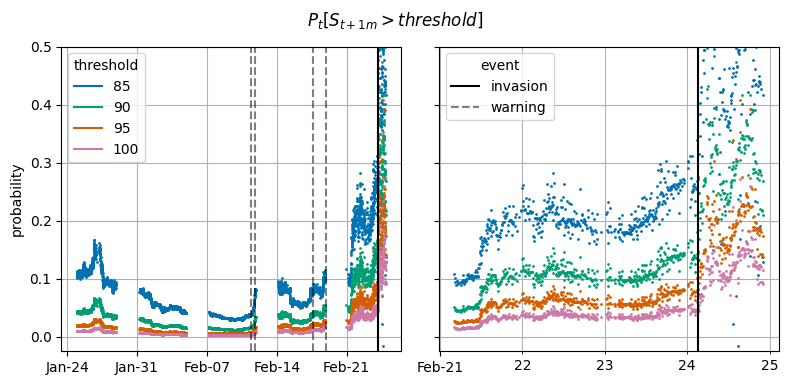

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=False, sharey=True)

p.plot(ax=axs[0], linestyle="none", marker="o", markersize=1)

for _dt, _warn in timeline.iloc[:-1, 0].items():
    axs[0].axvline(x=_dt, color="k", linestyle="--", alpha=0.5)

p.loc["2022-02-21":].plot(ax=axs[1], linestyle="none", marker="o", markersize=1)

axs[0].set_ylim(-0.025, 0.5)

# legend
legend_handles = [
    Line2D([0], [0], linestyle="-", color=_l._color, label=_l._label)
    for _l in axs[0].lines
] + [
    Line2D([0], [0], linestyle="-", color="k"),
    Line2D([0], [0], linestyle="--", color="k", alpha=0.5)
]
legend_labels = axs[0].get_legend_handles_labels()[1] + [
    "invasion", "warning"
]
axs[0].legend(legend_handles[:-2], legend_labels[:-2], title="threshold")
axs[1].legend(legend_handles[-2:], legend_labels[-2:], title="event")

# attr common to both axes
for _ax in axs:
    _ax.set_xlabel("", visible=None)
    _ax.axvline(x=timeline.index[-1], color="k")
    _ax.grid(which="both", axis="both")
    _ax.xaxis.set_major_formatter(DateFormatter("%b-%d"))

# xticks
axs[0].xaxis.set_major_locator(WeekdayLocator(byweekday=MO))
axs[1].xaxis.set_major_locator(MonthLocator(bymonth=2, bymonthday=21))
axs[1].xaxis.set_minor_locator(DayLocator())
axs[1].xaxis.set_minor_formatter(DateFormatter("%d"))
fig.autofmt_xdate(rotation=0, ha="center")

# labels, titles
axs[0].set_ylabel("probability")
plt.suptitle("$P_t[S_{t+1m} > threshold]$", y=0.95)

fig.tight_layout()

fig.savefig(OUT_PATH / "figures" / "prob-invasion-by-threshold.png",
            dpi=300)

plt.show()

The estimated probability of invasion oscillated around 5% for the threshold of 85, but rose to ~20% at the end of Feb 21st and 30% at the end of Feb 23rd, indicative of the FX markets growing more wary of the approaching invasion at least two days before it. Only the first two of the four warnings by the US officials had a noticeable effect on the probability.